# What's Your Jean-o-Type?

## Imports

In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import os

## Creating Dataset

### Hollister

In [2]:
import pandas as pd

hollister = pd.read_csv('data/hollister.csv')

keywords = ['skinny', 'straight', 'bootcut', 'baggy', 'wide']

def simplify_name(name):
    name = str(name).lower()

    # Specific phrase mappings
    if 'barrel leg' in name:
        return 'wide'
    if 'jegging' in name:
        return 'skinny'
    if 'relaxed' in name:
        return 'baggy'
    if 'slim' in name:
        return 'straight'
    if 'athletic' in name and 'slim' in name:
        return 'straight'

    # General keyword mappings
    if 'flare' in name:
        return 'bootcut'
    if 'boyfriend' in name:
        return 'baggy'
    if 'wide' in name:
        return 'wide'
    if 'boot' in name:
        return 'bootcut'
    if 'legging' in name:
        return 'skinny'
    if 'loose' in name:
        return 'baggy'
    if 'dad' in name or 'mom' in name:
        return 'straight'
    if 'taper' in name:
        return 'straight'
    if 'jogger' in name or 'cargo' in name:
        return 'baggy'

    for keyword in keywords:
        if keyword in name:
            return keyword

    return 'other'  

hollister['fit'] = hollister['name'].apply(simplify_name)

### Levi's

In [3]:
levis = pd.read_csv('data/levis.csv')

def simplify_name(name):
    name = str(name).lower()
    if 'boot' in name:
        return 'bootcut'
    if 'straight' in name:
        return 'straight'
    if 'slim' in name:
        return 'skinny'
    if 'skinny' in name:
        return 'skinny'
    elif 'legging' in name:
        return 'skinny'
    elif 'loose' in name:
        return 'baggy'
    elif 'dad' in name or 'mom' in name:
        return 'straight'
    elif 'taper' in name:
        return 'straight'
    elif 'jogger' in name or 'cargo' in name:
        return 'baggy'
    if 'speed' in name:
        return name  # Leave "speed jeans" unchanged
    if '511' in name or 'slim fit' in name or 'shaping slim' in name:
        return 'skinny'
    if 'skinny' in name or 'legging' in name:
        return 'skinny'
    if 'flare' in name or 'bell' in name:
        return 'bootcut'
    if 'wide' in name or 'culotte' in name or 'barrel' in name:
        return 'wide-leg'
    if 'boyfriend' in name or 'baggy' in name:
        return 'baggy'
    if 'relaxed' in name:
        return 'baggy'
    if 'carpenter' in name or 'overalls' in name or 'shortalls' in name:
        return 'baggy'
    if '505' in name or '501' in name or 'regular fit' in name or 'low pro' in name or 'ribcage full' in name or 'wedgie' in name or 'chino' in name:
        return 'straight'
    if 'column' in name or '701' in name or 'vintage clothing' in name:
        return 'straight'
    else:
      return name
levis['fit'] = levis['name'].apply(simplify_name)

### Lucky Brand

In [4]:
lucky = pd.read_csv('data/lucky.csv')

def simplify_name(name):
    name = str(name).lower()
    if 'boot' in name:
        return 'bootcut'
    if 'straight' in name:
        return 'straight'
    if 'slim' in name:
        return 'skinny'
    if 'skinny' in name:
        return 'skinny'
    elif 'legging' in name:
        return 'skinny'
    elif 'loose' in name:
        return 'baggy'
    elif 'dad' in name or 'mom' in name:
        return 'straight'
    elif 'taper' in name:
        return 'straight'
    elif 'jogger' in name or 'cargo' in name:
        return 'baggy'
    if '511' in name or 'slim fit' in name or 'shaping slim' in name:
        return 'skinny'
    if 'skinny' in name or 'legging' in name:
        return 'skinny'
    if 'flare' in name or 'bell' in name:
        return 'bootcut'
    if 'wide' in name or 'culotte' in name or 'barrel' in name:
        return 'wide-leg'
    if 'boyfriend' in name or 'baggy' in name:
        return 'baggy'
    if 'relaxed' in name:
        return 'baggy'
    if 'carpenter' in name or 'overalls' in name or 'shortalls' in name:
        return 'baggy'
    if 'short' in name:
        return 'other'
    if 'skirt' in name:
        return 'other'
    if 'jacket' in name:
        return 'other'
    if 'vest' in name:
        return 'other'
    if 'mid rise boy' in name:
        return 'other'
    if 'crop' in name:
        return 'other'
    else:
      return name
lucky['fit'] = lucky['name'].apply(simplify_name)

# Final Dataset

In [5]:
extra_wide = pd.read_csv('data/extra-wide-leg.csv')

In [6]:
jeans = pd.concat([hollister, levis, lucky], ignore_index=True)
jeans = jeans.drop(columns=['cell-image-link href'])
jeans = pd.concat([extra_wide, jeans], ignore_index = True)
jeans = jeans[jeans['fit'].isin(['baggy', 'wide-leg', 'skinny', 'straight', 'bootcut'])]
jeans = jeans.dropna(subset=['image'])
jeans['fit'].value_counts()

straight    335
baggy       251
skinny      137
bootcut     130
wide-leg     63
Name: fit, dtype: int64

## Image Creation

In [7]:
import pandas as pd
import os
import requests
from tqdm import tqdm
from PIL import Image
from io import BytesIO

In [8]:
def download_images(jeans_type, output_dir):

  jeans_type = jeans[jeans['fit'] == jeans_type]
  os.makedirs(output_dir, exist_ok=True)

  # Loop through and download + resize
  for i, url in tqdm(enumerate(jeans_type['image'])):
      if pd.isna(url):
          continue  # Skip missing links
      try:
          response = requests.get(url, timeout=10)
          if response.status_code == 200:
              # Load image from response
              img = Image.open(BytesIO(response.content)).convert("RGB")
              img = img.resize((224, 224))  # Resize to MobileNetV2 input size

              # Save as JPEG
              filename = f"{jeans_type}_{i}.jpg"
              img.save(os.path.join(output_dir, filename), format='JPEG')
          else:
              print(f"⚠️ Skipped {url} (status {response.status_code})")
      except Exception as e:
          print(f"❌ Error at {url}: {e}")



```
download_images('skinny', '/content/drive/MyDrive/Datahacks/data/skinny')
download_images('bootcut', '/content/drive/MyDrive/Datahacks/data/bootcut')
download_images('wide-leg', '/content/drive/MyDrive/Datahacks/data/wide-leg')
download_images('straight', '/content/drive/MyDrive/Datahacks/data/straight')
download_images('baggy', '/content/drive/MyDrive/Datahacks/data/baggy')
```





## Augmenting the Dataset

## Training and Testing

Found 1204 images belonging to 5 classes.
Found 300 images belonging to 5 classes.


Epoch 1/10
38/38 [==============================] - 29s 740ms/step - loss: 1.6495 - accuracy: 0.2774 - val_loss: 1.5321 - val_accuracy: 0.3367
Epoch 2/10
38/38 [==============================] - 28s 737ms/step - loss: 1.3565 - accuracy: 0.4286 - val_loss: 1.4226 - val_accuracy: 0.4700
Epoch 3/10
38/38 [==============================] - 31s 809ms/step - loss: 1.2258 - accuracy: 0.4975 - val_loss: 1.2181 - val_accuracy: 0.5233
Epoch 4/10
38/38 [==============================] - 30s 802ms/step - loss: 1.1666 - accuracy: 0.5249 - val_loss: 1.2462 - val_accuracy: 0.5200
Epoch 5/10
38/38 [==============================] - 29s 756ms/step - loss: 1.1158 - accuracy: 0.5332 - val_loss: 1.1649 - val_accuracy: 0.5700
Epoch 6/10
38/38 [==============================] - 28s 750ms/step - loss: 1.0377 - accuracy: 0.5731 - val_loss: 1.1732 - val_accuracy: 0.5600
Epoch 7/10
38/38 [==============================] - 31s 817ms/step - loss: 0.9719 - accuracy: 0.5997 - val_loss: 1.0584 - val_accuracy: 0.5933

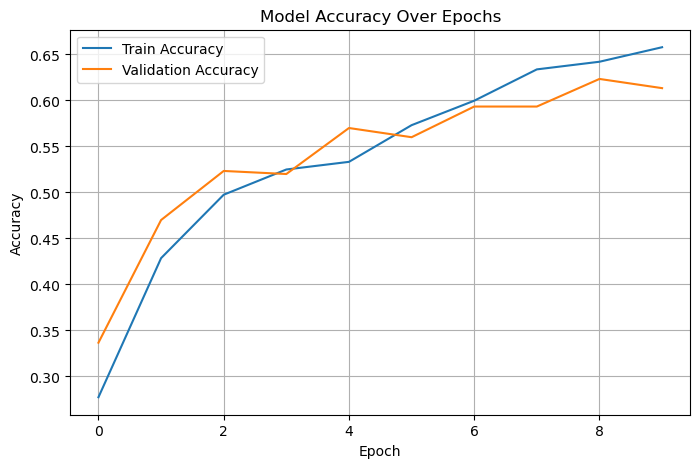

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report

# Parameters
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10
DATA_DIR = "data"

# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.1,
    rotation_range=10
)

train_gen = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_gen = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Load MobileNetV2 base
base_model = MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
)

base_model.trainable = False  # Freeze convolutional base

# Add custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
output = Dense(train_gen.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS
)

# Evaluate model
val_gen.reset()
y_pred = model.predict(val_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_gen.classes

# Get the full list of class labels from the training generator
class_labels = list(train_gen.class_indices.keys())

# Print classification report
print(classification_report(
    y_true,
    y_pred_classes,
    labels=np.arange(len(class_labels)),  # [0, 1, 2, ...]
    target_names=class_labels
))

# Plot training accuracy
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Model Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

## Confusion Matrix

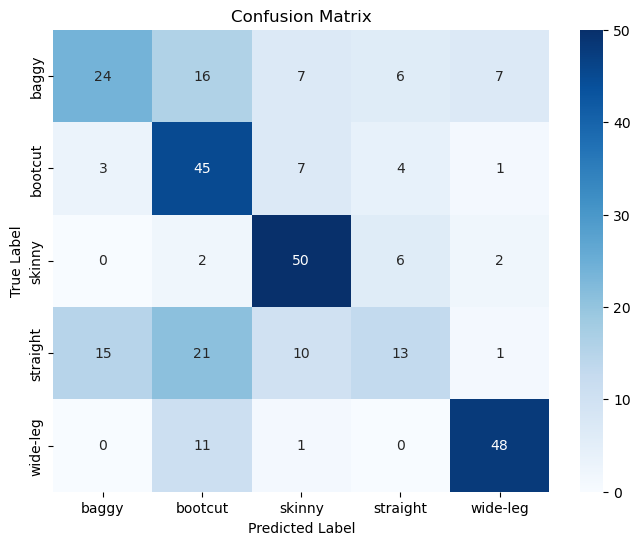

              precision    recall  f1-score   support

       baggy       0.57      0.40      0.47        60
     bootcut       0.47      0.75      0.58        60
      skinny       0.67      0.83      0.74        60
    straight       0.45      0.22      0.29        60
    wide-leg       0.81      0.80      0.81        60

    accuracy                           0.60       300
   macro avg       0.59      0.60      0.58       300
weighted avg       0.59      0.60      0.58       300



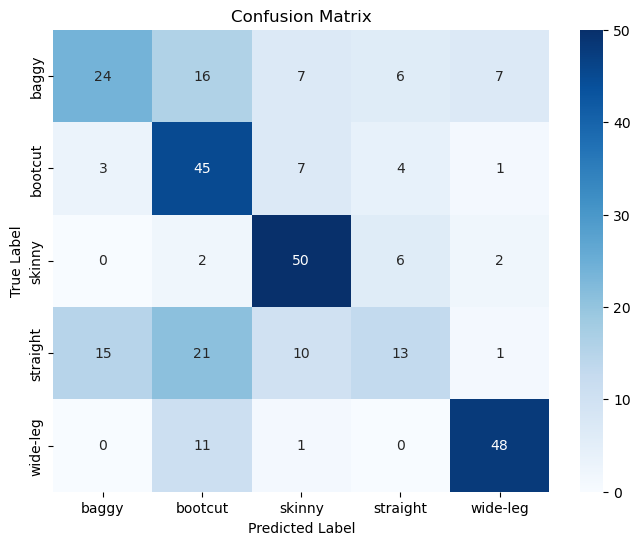

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Print classification report with full label mapping
print(classification_report(
    y_true,
    y_pred_classes,
    labels=np.arange(len(class_labels)),
    target_names=class_labels
))

# Plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


### Saving the Model

In [16]:
from tensorflow.keras.models import load_model, save_model
model.save("jean_fit_classifier.h5")

/Users/tvidyala/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
